# EGTA Framework Exploration

This notebook demonstrates how to use the Empirical Game-Theoretic Analysis (EGTA) framework to explore strategic interactions between agents deciding how to allocate their trading between traditional CDA markets and the MELO mechanism.

## Overview

1. Basic EGTA setup and running experiments
2. Analyzing equilibria and visualizing results
3. Parameter sweeps to understand how market conditions affect strategy selection
4. Advanced techniques for exploring larger strategy spaces

## 1. Setup and Imports

In [1]:
import os
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, List, Tuple, Any, Optional
from tqdm.notebook import tqdm
import fix_path
import widgetsnbextension

"""
Example code to fix import issues in the egta_exploration.ipynb notebook.

Copy the following code to the first cell of your notebook to fix
the 'No module named marketsim' error.
"""
import os
import sys
import json

notebook_dir = os.getcwd()  

if notebook_dir.endswith('examples'):
    project_root = os.path.dirname(notebook_dir)
else:
    project_root = notebook_dir
    while not os.path.exists(os.path.join(project_root, 'marketsim')) and project_root != '/':
        project_root = os.path.dirname(project_root)
        
    if not os.path.exists(os.path.join(project_root, 'marketsim')):
        project_root = os.path.dirname(notebook_dir)

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added {project_root} to Python path")
else:
    print(f"{project_root} already in Python path")

print(f"Current working directory: {notebook_dir}")
print(f"Project root directory: {project_root}")
print(f"sys.path: {sys.path[0]}")

try:
    import fix_path
    fix_path.add_project_root_to_path()
except ImportError:
    print("Could not import fix_path module, using direct path configuration")

try:
    import marketsim
    print("Successfully imported marketsim module")
except ImportError as e:
    print(f"Error importing marketsim: {e}")
    print("Please make sure marketsim is installed or the path is correctly set")

from marketsim.egta.egta import EGTA
from marketsim.egta.simulators.melo_wrapper import MeloSimulator
from marketsim.egta.schedulers.dpr import DPRScheduler
from marketsim.egta.schedulers.random import RandomScheduler
from marketsim.egta.utils.visualization import (
    plot_equilibria, 
    plot_strategy_frequency, 
    plot_payoff_matrix,
    plot_regret_landscape,
    create_visualization_report
)
from marketsim.egta.core.game import Game
from marketsim.egta.solvers.equilibria import replicator_dynamics, quiesce, regret

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

Matplotlib created a temporary cache directory at /var/folders/fh/fwc37qhn04d8sxp65hwv1kxm0000gn/T/matplotlib-ac_a6sae because the default path (/Users/gabesmithline/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Added /Users/gabesmithline/Desktop/SRG/melo_project to Python path
Current working directory: /Users/gabesmithline/Desktop/SRG/melo_project/examples
Project root directory: /Users/gabesmithline/Desktop/SRG/melo_project
sys.path: /Users/gabesmithline/Desktop/SRG/melo_project
/Users/gabesmithline/Desktop/SRG/melo_project already in Python path
Successfully imported marketsim module


In [2]:
!jupyter nbextension enable --py widgetsnbextension


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


## 2. Basic EGTA Experiment

Let's run a basic EGTA experiment to analyze how agents allocate trading between CDA and MELO markets.

In [3]:
# Create output directory
output_dir = 'results/egta_notebook'
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Create MELO simulator with default parameters
simulator = MeloSimulator(
    num_strategic=10,  # Number of strategic MOBI agents
    sim_time=100,  # Simulation time horizon
    lam=0.01,         # Arrival rate
    mean=100,        # Mean fundamental value
    r=.9,          # Mean reversion rate
    q_max=10,        # Maximum inventory
    holding_period=1, # MELO holding period
    reps=100          # Number of simulation repetitions per profile
)

# Get available strategies
strategies = simulator.get_strategies()
print(f"Available strategies: {strategies}")

# Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

Available strategies: ['MELO_100_0', 'MELO_0_100']

Strategy parameters:
  MELO_100_0: CDA=1.00, MELO=0.00
  MELO_0_100: CDA=0.00, MELO=1.00


In [5]:
# Create DPR scheduler with reduction
scheduler = DPRScheduler(
    strategies=strategies,
    num_players=10,           # Full game has 10 players (N)
    reduction_size=4,         # Reduced game has 4 players (n)
    subgame_size=min(4, len(strategies)),
    batch_size=5,
    seed=42
)

# Print information about the scaling
print(f"DPR Scaling Info: {scheduler.get_scaling_info()}")
# Expected output: DPR Scaling Info: {'full_game_players'
# Create EGTA framework
egta = EGTA(
    simulator=simulator,
    scheduler=scheduler,
    device="cpu",     # Use CPU for computation
    output_dir=output_dir,
    max_profiles=1000,   # Maximum number of profiles to simulate
    seed=42           # Random seed for reproducibility
)

DPR Scaling Info: {'full_game_players': 10, 'reduced_game_players': 4, 'scaling_factor': 3.0, 'is_reduced': True}


In [6]:
# Run EGTA (this may take some time)
print("Starting EGTA experiment...")
print(f"Analyzing market allocation strategies: {strategies}")

game = egta.run(
    max_iterations=100, 
    profiles_per_iteration=100,  
    save_frequency=1,   
    verbose=True         
)

print("\nEGTA experiment completed!")

Starting EGTA experiment...
Analyzing market allocation strategies: ['MELO_100_0', 'MELO_0_100']

Iteration 1/100
Simulating 5 profiles...
Simulating profile 1/5: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1990.0591])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 9950.29541015625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1990.0591])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -9950.29541015625
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([315.0715])
Agent 17 MELO Profit before trade: 9950.29541015625
Agent 17 MELO Profit after trade: 8374.937744140625
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([315.0715])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1575.357666015625


  4%|▍         | 4/100 [00:00<00:02, 35.61it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -0.22415078749199324
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1.1207539374599662
MELO Trade: Agent 16, Side -1, Quantity 5, Price -0.22415078749199324
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1.1207539374599662
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-945.0298])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 4725.14892578125
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-945.0298])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -4725.14892578125
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([221.4654])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1107.3268127441406
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([221.4654])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1107.3268127441406
MELO Trade: Agent 17, Side 1, Quantity 5, Price te

 15%|█▌        | 15/100 [00:00<00:01, 48.05it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([1831.1985])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -9155.992431640625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1831.1985])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 9155.992431640625
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([447.4616])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2237.3080444335938
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([447.4616])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2237.3080444335938
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-360.0515])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1800.2574157714844
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-360.0515])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1800.2574157714844
MELO Trade: Agent 18, Side 1, Quantity 5, Price te

 29%|██▉       | 29/100 [00:00<00:01, 58.41it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([641.5489])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -3207.7444458007812
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([641.5489])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 3207.7444458007812
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-2225.6541])
Agent 17 MELO Profit before trade: 3207.7444458007812
Agent 17 MELO Profit after trade: 14336.014709472656
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([-2225.6541])
Agent 16 MELO Profit before trade: -3207.7444458007812
Agent 16 MELO Profit after trade: -14336.014709472656
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1655.5452])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8277.725830078125
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1655.5452])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8277.725830078125
MELO Trade:

 37%|███▋      | 37/100 [00:00<00:01, 62.79it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1430.2889])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -7151.4447021484375
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1430.2889])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 7151.4447021484375
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([548.8290])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -2744.1448974609375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([548.8290])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2744.1448974609375
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([984.3995])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -4921.9976806640625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([984.3995])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 4921.9976806640625
MELO Trade: Agent 16, Side 1, Quantity 5, Price te

 45%|████▌     | 45/100 [00:00<00:00, 66.55it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-532.6180])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2663.0899047851562
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-532.6180])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2663.0899047851562
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([330.8174])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1654.0872192382812
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([330.8174])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1654.0872192382812
MELO Trade: Agent 16, Side 1, Quantity 5, Price -316.4173209740103
Agent 16 MELO Profit before trade: -1654.0872192382812
Agent 16 MELO Profit after trade: -72.00061436822989
MELO Trade: Agent 18, Side -1, Quantity 5, Price -316.4173209740103
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1582.0866048700514
MELO Trade: Agent 17, Side 1, Qu

 60%|██████    | 60/100 [00:00<00:00, 68.53it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -323.8054043083582
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1619.027021541791
MELO Trade: Agent 16, Side -1, Quantity 5, Price -323.8054043083582
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1619.027021541791
MELO Trade: Agent 18, Side 1, Quantity 5, Price -323.8054043083582
Agent 18 MELO Profit before trade: 1619.027021541791
Agent 18 MELO Profit after trade: 3238.054043083582
MELO Trade: Agent 16, Side -1, Quantity 5, Price -323.8054043083582
Agent 16 MELO Profit before trade: -1619.027021541791
Agent 16 MELO Profit after trade: -3238.054043083582
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([84.4244])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -422.1219253540039
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([84.4244])
Agent 16 MELO Profit before trade: -3238.054043083582
Agent 16 MELO Profit after trade: -2815.9321177295783
MELO Tra

 76%|███████▌  | 76/100 [00:01<00:00, 71.90it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-568.8105])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2844.0524291992188
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-568.8105])
Agent 18 MELO Profit before trade: 4396.7938232421875
Agent 18 MELO Profit after trade: 1552.7413940429688
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1621.3523])
Agent 17 MELO Profit before trade: -4396.7938232421875
Agent 17 MELO Profit after trade: -12503.555297851562
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1621.3523])
Agent 16 MELO Profit before trade: 2844.0524291992188
Agent 16 MELO Profit after trade: 10950.813903808594
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-1109.7766])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 5548.883056640625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1109.7766])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5548.88305664

 92%|█████████▏| 92/100 [00:01<00:00, 74.24it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([971.4406])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -4857.203063964844
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([971.4406])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4857.203063964844
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1110.5750])
Agent 18 MELO Profit before trade: 4857.203063964844
Agent 18 MELO Profit after trade: -695.6716918945312
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1110.5750])
Agent 16 MELO Profit before trade: -4857.203063964844
Agent 16 MELO Profit after trade: 695.6716918945312
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([438.4709])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2192.3544311523438
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([438.4709])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2192.3544311523438
MELO Trade: Agent 18,

100%|██████████| 100/100 [00:01<00:00, 66.17it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([666.8209])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -3334.1043090820312
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([666.8209])
Agent 17 MELO Profit before trade: -1453.6577121272426
Agent 17 MELO Profit after trade: 1880.4465969547887
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1045.3771])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5226.8853759765625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1045.3771])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5226.8853759765625
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([33.6048])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -168.02419662475586
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([33.6048])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 168.02419662475586
Simulating profile 2/5: ['MELO_0_1

  0%|          | 0/100 [00:00<?, ?it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 116.57014911749937
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -582.8507455874968
MELO Trade: Agent 18, Side -1, Quantity 5, Price 116.57014911749937
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 582.8507455874968
MELO Trade: Agent 15, Side 1, Quantity 5, Price 116.57014911749937
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -582.8507455874968
MELO Trade: Agent 16, Side -1, Quantity 5, Price 116.57014911749937
Agent 16 MELO Profit before trade: -582.8507455874968
Agent 16 MELO Profit after trade: 0.0
MELO Trade: Agent 17, Side 1, Quantity 5, Price -219.4992027715508
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1097.496013857754
MELO Trade: Agent 15, Side -1, Quantity 5, Price -219.4992027715508
Agent 15 MELO Profit before trade: -582.8507455874968
Agent 15 MELO Profit after trade: -1680.3467594452509
MELO Trade: Agent 16, Side 1, Quantit

  9%|▉         | 9/100 [00:00<00:01, 87.02it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -372.9804210077033
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1864.9021050385163
MELO Trade: Agent 18, Side -1, Quantity 5, Price -372.9804210077033
Agent 18 MELO Profit before trade: -2118.6409662225747
Agent 18 MELO Profit after trade: -3983.543071261091
MELO Trade: Agent 17, Side 1, Quantity 5, Price 114.69380528639924
Agent 17 MELO Profit before trade: 1864.9021050385163
Agent 17 MELO Profit after trade: 1291.4330786065202
MELO Trade: Agent 16, Side -1, Quantity 5, Price 114.69380528639924
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 573.4690264319962
MELO Trade: Agent 17, Side 1, Quantity 5, Price 115.23468592252294
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -576.1734296126147
MELO Trade: Agent 16, Side -1, Quantity 5, Price 115.23468592252294
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 576.1734296126147
MELO Trade: Agent 18, 

 18%|█▊        | 18/100 [00:00<00:00, 87.39it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 208.62386602296291
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1043.1193301148146
MELO Trade: Agent 17, Side -1, Quantity 5, Price 208.62386602296291
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1043.1193301148146
MELO Trade: Agent 17, Side 1, Quantity 5, Price 208.62386602296291
Agent 17 MELO Profit before trade: 1043.1193301148146
Agent 17 MELO Profit after trade: 0.0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 208.62386602296291
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1043.1193301148146
MELO Trade: Agent 17, Side 1, Quantity 5, Price 208.62386602296291
Agent 17 MELO Profit before trade: 0.0
Agent 17 MELO Profit after trade: -1043.1193301148146
MELO Trade: Agent 15, Side -1, Quantity 5, Price 208.62386602296291
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 1043.1193301148146
MELO Trade: Agent 16, Side 1, Quantity 5, Price 2

 27%|██▋       | 27/100 [00:00<00:00, 86.66it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -97.78632357427422
Agent 18 MELO Profit before trade: 488.9316178713711
Agent 18 MELO Profit after trade: 977.8632357427422
MELO Trade: Agent 17, Side -1, Quantity 5, Price -97.78632357427422
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -488.9316178713711
MELO Trade: Agent 17, Side 1, Quantity 5, Price -97.78632357427422
Agent 17 MELO Profit before trade: -488.9316178713711
Agent 17 MELO Profit after trade: 0.0
MELO Trade: Agent 15, Side -1, Quantity 5, Price -97.78632357427422
Agent 15 MELO Profit before trade: -488.9316178713711
Agent 15 MELO Profit after trade: -977.8632357427422
MELO Trade: Agent 15, Side 1, Quantity 5, Price 20.03691335166353
Agent 15 MELO Profit before trade: -977.8632357427422
Agent 15 MELO Profit after trade: -1078.0478025010598
MELO Trade: Agent 17, Side -1, Quantity 5, Price 20.03691335166353
Agent 17 MELO Profit before trade: 0.0
Agent 17 MELO Profit after trade: 100.18456675831764
MEL

 36%|███▌      | 36/100 [00:00<00:00, 84.22it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price -851.9541151675597
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4259.770575837799
MELO Trade: Agent 15, Side -1, Quantity 5, Price -851.9541151675597
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -4259.770575837799
MELO Trade: Agent 17, Side 1, Quantity 5, Price -849.2114520003522
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 4246.057260001761
MELO Trade: Agent 15, Side -1, Quantity 5, Price -849.2114520003522
Agent 15 MELO Profit before trade: -4259.770575837799
Agent 15 MELO Profit after trade: -8505.82783583956
MELO Trade: Agent 15, Side 1, Quantity 5, Price -280.7318397646241
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 1403.6591988231205
MELO Trade: Agent 18, Side -1, Quantity 5, Price -280.7318397646241
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1403.6591988231205
MELO Trade: Agent 18, Side 1, Quantity 5

 45%|████▌     | 45/100 [00:00<00:00, 85.03it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 42.19069330951898
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -210.95346654759487
MELO Trade: Agent 16, Side -1, Quantity 5, Price 42.19069330951898
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 210.95346654759487
MELO Trade: Agent 18, Side 1, Quantity 5, Price 436.0158545079539
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2180.0792725397696
MELO Trade: Agent 15, Side -1, Quantity 5, Price 436.0158545079539
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 2180.0792725397696
MELO Trade: Agent 16, Side 1, Quantity 5, Price 85.80309495218526
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -429.0154747609263
MELO Trade: Agent 17, Side -1, Quantity 5, Price 85.80309495218526
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 429.0154747609263
MELO Trade: Agent 15, Side 1, Quantity 5, Price 85.803094952

 54%|█████▍    | 54/100 [00:00<00:00, 84.52it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -396.9742487496014
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1984.871243748007
MELO Trade: Agent 18, Side -1, Quantity 5, Price -396.9742487496014
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1984.871243748007
MELO Trade: Agent 17, Side 1, Quantity 5, Price -396.9742487496014
Agent 17 MELO Profit before trade: 1984.871243748007
Agent 17 MELO Profit after trade: 3969.742487496014
MELO Trade: Agent 15, Side -1, Quantity 5, Price -396.9742487496014
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -1984.871243748007
MELO Trade: Agent 17, Side 1, Quantity 5, Price -89.43335791626747
Agent 17 MELO Profit before trade: 3969.742487496014
Agent 17 MELO Profit after trade: 4416.909277077351
MELO Trade: Agent 16, Side -1, Quantity 5, Price -89.43335791626747
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -447.16678958133735
MELO Trade: Agent 17, Sid

 63%|██████▎   | 63/100 [00:00<00:00, 86.11it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price 59.1229954176556
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -295.614977088278
MELO Trade: Agent 15, Side -1, Quantity 5, Price 59.1229954176556
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 295.614977088278
MELO Trade: Agent 15, Side 1, Quantity 5, Price 59.1229954176556
Agent 15 MELO Profit before trade: 295.614977088278
Agent 15 MELO Profit after trade: 0.0
MELO Trade: Agent 16, Side -1, Quantity 5, Price 59.1229954176556
Agent 16 MELO Profit before trade: -295.614977088278
Agent 16 MELO Profit after trade: 0.0
MELO Trade: Agent 16, Side 1, Quantity 5, Price 445.68974605396755
Agent 16 MELO Profit before trade: 0.0
Agent 16 MELO Profit after trade: -2228.4487302698376
MELO Trade: Agent 18, Side -1, Quantity 5, Price 445.68974605396755
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2228.4487302698376
MELO Trade: Agent 18, Side 1, Quantity 5, Price 465.2722099267

 72%|███████▏  | 72/100 [00:00<00:00, 85.81it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price 492.70798455308113
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2463.5399227654057
MELO Trade: Agent 15, Side -1, Quantity 5, Price 492.70798455308113
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 2463.5399227654057
MELO Trade: Agent 18, Side 1, Quantity 5, Price 492.70798455308113
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2463.5399227654057
MELO Trade: Agent 15, Side -1, Quantity 5, Price 492.70798455308113
Agent 15 MELO Profit before trade: 2463.5399227654057
Agent 15 MELO Profit after trade: 4927.079845530811
MELO Trade: Agent 17, Side 1, Quantity 5, Price 489.9594909455591
Agent 17 MELO Profit before trade: -2463.5399227654057
Agent 17 MELO Profit after trade: -4913.337377493201
MELO Trade: Agent 15, Side -1, Quantity 5, Price 489.9594909455591
Agent 15 MELO Profit before trade: 4927.079845530811
Agent 15 MELO Profit after trade: 7376.877300258607
MELO T

 81%|████████  | 81/100 [00:00<00:00, 83.38it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 553.9307447497356
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2769.653723748678
MELO Trade: Agent 15, Side -1, Quantity 5, Price 553.9307447497356
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 2769.653723748678
MELO Trade: Agent 17, Side 1, Quantity 5, Price 287.2377017665506
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1436.1885088327529
MELO Trade: Agent 16, Side -1, Quantity 5, Price 287.2377017665506
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1436.1885088327529
MELO Trade: Agent 15, Side 1, Quantity 5, Price 278.4374937685123
Agent 15 MELO Profit before trade: 2769.653723748678
Agent 15 MELO Profit after trade: 1377.4662549061168
MELO Trade: Agent 18, Side -1, Quantity 5, Price 278.4374937685123
Agent 18 MELO Profit before trade: -2769.653723748678
Agent 18 MELO Profit after trade: -1377.4662549061168
MELO Trade: Agent 16, Side 

 90%|█████████ | 90/100 [00:01<00:00, 81.90it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -382.89802997961317
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 1914.4901498980657
MELO Trade: Agent 18, Side -1, Quantity 5, Price -382.89802997961317
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1914.4901498980657
MELO Trade: Agent 17, Side 1, Quantity 5, Price -175.32471331646903
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 876.6235665823451
MELO Trade: Agent 15, Side -1, Quantity 5, Price -175.32471331646903
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -876.6235665823451
MELO Trade: Agent 15, Side 1, Quantity 5, Price -457.9179533609929
Agent 15 MELO Profit before trade: -876.6235665823451
Agent 15 MELO Profit after trade: 1412.9662002226196
MELO Trade: Agent 16, Side -1, Quantity 5, Price -457.9179533609929
Agent 16 MELO Profit before trade: 1914.4901498980657
Agent 16 MELO Profit after trade: -375.099616906899
MELO Trade: Agent 

100%|██████████| 100/100 [00:01<00:00, 83.03it/s]


MELO Trade: Agent 15, Side 1, Quantity 5, Price 258.7966769240174
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -1293.983384620087
MELO Trade: Agent 17, Side -1, Quantity 5, Price 258.7966769240174
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1293.983384620087
MELO Trade: Agent 18, Side 1, Quantity 5, Price 258.7966769240174
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1293.983384620087
MELO Trade: Agent 15, Side -1, Quantity 5, Price 258.7966769240174
Agent 15 MELO Profit before trade: -1293.983384620087
Agent 15 MELO Profit after trade: 0.0
MELO Trade: Agent 15, Side 1, Quantity 5, Price 400.2019644255406
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -2001.009822127703
MELO Trade: Agent 16, Side -1, Quantity 5, Price 400.2019644255406
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 2001.009822127703
MELO Trade: Agent 17, Side 1, Quantity 5, Price 400.201964425

100%|██████████| 100/100 [00:01<00:00, 59.24it/s]


Simulating profile 4/5: ['MELO_0_100', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 100/100 [00:01<00:00, 64.99it/s]


Simulating profile 5/5: ['MELO_0_100', 'MELO_0_100', 'MELO_100_0', 'MELO_100_0']


  7%|▋         | 7/100 [00:00<00:01, 68.20it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-492.4050])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2462.025146484375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-492.4050])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2462.025146484375
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1641.6254])
Agent 18 MELO Profit before trade: 2462.025146484375
Agent 18 MELO Profit after trade: 10670.151977539062
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1641.6254])
Agent 17 MELO Profit before trade: -2462.025146484375
Agent 17 MELO Profit after trade: -10670.151977539062


 15%|█▌        | 15/100 [00:00<00:01, 71.21it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1571.7700])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 7858.85009765625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1571.7700])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -7858.85009765625


 23%|██▎       | 23/100 [00:00<00:01, 69.52it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([251.5340])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -1257.6699829101562
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([251.5340])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 1257.6699829101562
MELO Trade: Agent 18, Side 1, Quantity 5, Price 558.81273431521
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -2794.06367157605
MELO Trade: Agent 17, Side -1, Quantity 5, Price 558.81273431521
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 2794.06367157605


 30%|███       | 30/100 [00:00<00:01, 69.64it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-402.5219])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2012.6095581054688
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-402.5219])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2012.6095581054688


 44%|████▍     | 44/100 [00:00<00:00, 69.28it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([835.6547])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -4178.2733154296875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([835.6547])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 4178.2733154296875
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([180.2892])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -901.4459228515625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([180.2892])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 901.4459228515625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1267.5068])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -6337.5341796875
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1267.5068])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 6337.5341796875


 60%|██████    | 60/100 [00:00<00:00, 70.59it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1705.6340])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8528.170166015625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1705.6340])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8528.170166015625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-1261.4368])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 6307.183837890625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1261.4368])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -6307.183837890625
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([416.8192])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -2084.0957641601562
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([416.8192])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 2084.0957641601562


 75%|███████▌  | 75/100 [00:01<00:00, 68.38it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1722.9452])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -8614.725952148438
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1722.9452])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 8614.725952148438
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-126.9042])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 634.5211791992188
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-126.9042])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -634.5211791992188
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([177.4903])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -887.4514770507812
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([177.4903])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 887.4514770507812
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor

 89%|████████▉ | 89/100 [00:01<00:00, 65.60it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1523.2910])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -7616.455078125
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1523.2910])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 7616.455078125
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1317.8568])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -6589.2840576171875
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1317.8568])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 6589.2840576171875
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-775.4034])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 3877.0169067382812
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-775.4034])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -3877.0169067382812
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor

100%|██████████| 100/100 [00:01<00:00, 68.08it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-759.2969])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 3796.484375
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-759.2969])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -3796.484375
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-546.8445])
Agent 17 MELO Profit before trade: -3796.484375
Agent 17 MELO Profit after trade: -1062.261962890625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-546.8445])
Agent 18 MELO Profit before trade: 3796.484375
Agent 18 MELO Profit after trade: 1062.261962890625
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([1187.1489])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -5935.74462890625
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([1187.1489])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 5935.74462890625
MELO Trade: Agent 18, Side 1, Quantity 5, Pri

## 3. Analyzing Equilibria

Now let's analyze the equilibria found by the EGTA process.

In [7]:
# Analyze equilibria
analysis = egta.analyze_equilibria(verbose=True)

# Save analysis
with open(os.path.join(output_dir, 'analysis.json'), 'w') as f:
    json.dump(analysis, f, indent=2)


Equilibria Analysis
Number of equilibria: 1
Average regret: 0.000000
Average support size: 1.00
Support size range: 1 - 1

Top strategies:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


Top strategies by frequency:
  MELO_100_0: 1.0000
  MELO_0_100: 0.0000


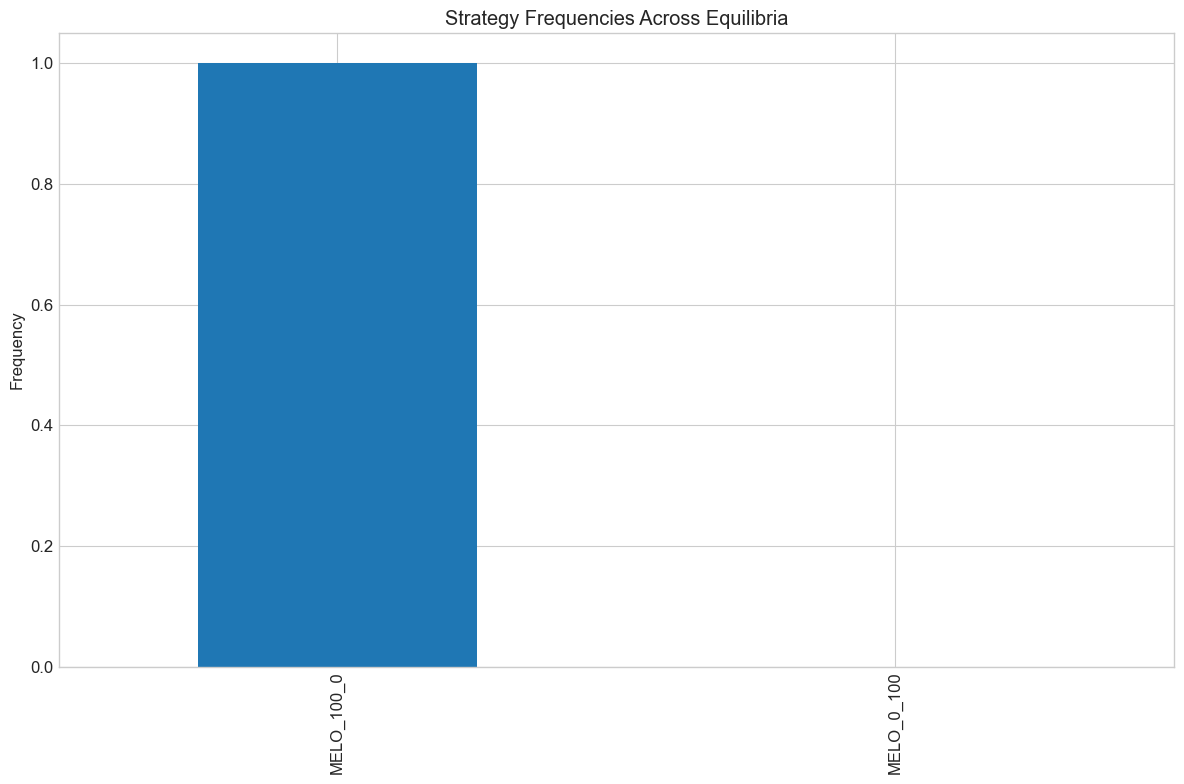

In [8]:
# Print top strategies
print("Top strategies by frequency:")
for strategy, freq in analysis['top_strategies']:
    print(f"  {strategy}: {freq:.4f}")

# Create a bar chart of strategy frequencies
strategy_freqs = pd.Series(analysis['strategy_frequencies'])
strategy_freqs.sort_values(ascending=False).plot(kind='bar')
plt.title('Strategy Frequencies Across Equilibria')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  

## 4. Visualizing Results

## TODO FIX THIS

In [9]:
# Plot the equilibria as a heatmap
'''
plot_equilibria(
    game=game,
    equilibria=egta.equilibria,
    output_file=os.path.join(output_dir, 'equilibria.png'),
    show=True
)
'''

"\nplot_equilibria(\n    game=game,\n    equilibria=egta.equilibria,\n    output_file=os.path.join(output_dir, 'equilibria.png'),\n    show=True\n)\n"

In [10]:
# Plot strategy frequency
'''
plot_strategy_frequency(
    equilibria=egta.equilibria,
    strategy_names=game.strategy_names,
    output_file=os.path.join(output_dir, 'strategy_frequency.png'),
    show=True
)
'''

"\nplot_strategy_frequency(\n    equilibria=egta.equilibria,\n    strategy_names=game.strategy_names,\n    output_file=os.path.join(output_dir, 'strategy_frequency.png'),\n    show=True\n)\n"

In [11]:
# Plot payoff matrix
''''
plot_payoff_matrix(
    game=game,
    output_file=os.path.join(output_dir, 'payoff_matrix.png'),
    show=True
)
'''

"'\nplot_payoff_matrix(\n    game=game,\n    output_file=os.path.join(output_dir, 'payoff_matrix.png'),\n    show=True\n)\n"

In [12]:
# Plot regret landscapes for pairs of strategies
# This helps visualize where the equilibria are located
''''
if len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies
    for i in range(len(game.strategy_names)):
        for j in range(i+1, len(game.strategy_names)):
            plot_regret_landscape(
                game=game,
                strategies=[game.strategy_names[i], game.strategy_names[j]],
                resolution=50,  # Reduced resolution for speed
                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),
                show=True
            )
'''

"'\nif len(game.strategy_names) <= 5:  # Only if we have a manageable number of strategies\n    for i in range(len(game.strategy_names)):\n        for j in range(i+1, len(game.strategy_names)):\n            plot_regret_landscape(\n                game=game,\n                strategies=[game.strategy_names[i], game.strategy_names[j]],\n                resolution=50,  # Reduced resolution for speed\n                output_file=os.path.join(output_dir, f'regret_landscape_{i}_{j}.png'),\n                show=True\n            )\n"

In [13]:
# Create a comprehensive visualization report
'''
vis_dir = os.path.join(output_dir, 'visualizations')
report_path = create_visualization_report(
    game=game,
    equilibria=egta.equilibria,
    output_dir=vis_dir
)

print(f"Visualization report saved to {report_path}")
print("Open this HTML file in a browser to view the visualization report")
'''

'\nvis_dir = os.path.join(output_dir, \'visualizations\')\nreport_path = create_visualization_report(\n    game=game,\n    equilibria=egta.equilibria,\n    output_dir=vis_dir\n)\n\nprint(f"Visualization report saved to {report_path}")\nprint("Open this HTML file in a browser to view the visualization report")\n'

## 5. Parameter Sweeps

Now let's explore how different market conditions affect the equilibrium strategies by running parameter sweeps.

In [14]:
def run_experiment(holding_period, lam):
    """Run an EGTA experiment with specific parameters."""
    # Create experiment directory
    exp_dir = f"{output_dir}/sweep_h{holding_period}_lam{lam}"
    os.makedirs(exp_dir, exist_ok=True)
    
    # Create simulator with specific parameters
    simulator = MeloSimulator(
        num_strategic=10,
        sim_time=1000,
        lam=lam,             # Vary arrival rate
        mean=100,
        r=0.05,
        q_max=10,
        holding_period=holding_period,  # Vary holding period
        reps=2  # Use fewer repetitions for speed
    )
    
    scheduler = DPRScheduler(
        strategies=strategies,
        num_players=10,           # Full game has 10 players (N)
        reduction_size=4,         # Reduced game has 4 players (n)
        subgame_size=min(3, len(strategies)),
        batch_size=5,
        seed=42
    )

    
    # Create EGTA framework
    egta = EGTA(
        simulator=simulator,
        scheduler=scheduler,
        device="cpu",
        output_dir=exp_dir,
        max_profiles=30,
        seed=42
    )
    
    # Run with fewer iterations for the parameter sweep
    game = egta.run(
        max_iterations=3,
        profiles_per_iteration=3,
        save_frequency=1,
        verbose=False  # Less verbose for parameter sweep
    )
    
    # Analyze equilibria
    analysis = egta.analyze_equilibria(verbose=False)
    
    # Save analysis
    with open(os.path.join(exp_dir, 'analysis.json'), 'w') as f:
        json.dump(analysis, f, indent=2)
    
    return {
        'holding_period': holding_period,
        'lam': lam,
        'equilibria': [(mix.tolist(), float(reg)) for mix, reg in egta.equilibria],
        'strategy_frequencies': analysis['strategy_frequencies'],
        'top_strategies': analysis['top_strategies']
    }

In [15]:
# Define parameter grid
holding_periods = [1, 5, 10]  # Different MELO holding periods
lambdas = [0.05, 0.1, 0.2]    # Different arrival rates

# Run experiments
results = []
for h in holding_periods:
    print(f"Processing holding period: {h}")
    for lam in lambdas:
        print(f"\nRunning experiment with holding_period={h}, lambda={lam}")
        result = run_experiment(h, lam)
        results.append(result)
        print(f"Completed experiment. Found {len(result['equilibria'])} equilibria.")

# Save all results
with open(os.path.join(output_dir, 'parameter_sweep_results.json'), 'w') as f:
    json.dump(results, f, indent=2)

Processing holding period: 1

Running experiment with holding_period=1, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([118.0451])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -590.2253723144531
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([118.0451])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 590.2253723144531
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1442.8738])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -7214.368896484375
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([1442.8738])
Agent 16 MELO Profit before trade: -590.2253723144531
Agent 16 MELO Profit after trade: 6624.143524169922
MELO Trade: Agent 16, Side 1, Quantity 5, Price 642.0039463561119
Agent 16 MELO Profit before trade: 6624.143524169922
Agent 16 MELO Profit after trade: 3414.1237923893623
MELO Trade: Agent 17, Side -1, Quantity 5, Price 642.0039463561119
Agent 17 MELO Profit before trade: -7214.368896484375
Agent 17 MELO Profit after trade: -4004.3491647038154
MELO T

 50%|█████     | 1/2 [00:00<00:00,  1.40it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -125.73150031611308
Agent 16 MELO Profit before trade: 13734.90199791978
Agent 16 MELO Profit after trade: 14363.559499500345
MELO Trade: Agent 18, Side -1, Quantity 5, Price -125.73150031611308
Agent 18 MELO Profit before trade: -7602.200785004221
Agent 18 MELO Profit after trade: -8230.858286584786
MELO Trade: Agent 16, Side 1, Quantity 5, Price 563.0384824551982
Agent 16 MELO Profit before trade: 14363.559499500345
Agent 16 MELO Profit after trade: 11548.367087224353
MELO Trade: Agent 18, Side -1, Quantity 5, Price 563.0384824551982
Agent 18 MELO Profit before trade: -8230.858286584786
Agent 18 MELO Profit after trade: -5415.665874308795
MELO Trade: Agent 18, Side 1, Quantity 5, Price 477.7421744900933
Agent 18 MELO Profit before trade: -5415.665874308795
Agent 18 MELO Profit after trade: -7804.376746759261
MELO Trade: Agent 17, Side -1, Quantity 5, Price 477.7421744900933
Agent 17 MELO Profit before trade: -6132.701212915558
Agent 17 

100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 1299.2423061099707
Agent 16 MELO Profit before trade: 19605.288338666673
Agent 16 MELO Profit after trade: 13109.076808116819
MELO Trade: Agent 17, Side -1, Quantity 5, Price 1299.2423061099707
Agent 17 MELO Profit before trade: 8562.317720937823
Agent 17 MELO Profit after trade: 15058.529251487676
MELO Trade: Agent 18, Side 1, Quantity 5, Price 431.61476165638965
Agent 18 MELO Profit before trade: -28167.606059604495
Agent 18 MELO Profit after trade: -30325.679867886443
MELO Trade: Agent 16, Side -1, Quantity 5, Price 431.61476165638965
Agent 16 MELO Profit before trade: 13109.076808116819
Agent 16 MELO Profit after trade: 15267.150616398767
MELO Trade: Agent 16, Side 1, Quantity 5, Price 1421.74210498263
Agent 16 MELO Profit before trade: 15267.150616398767
Agent 16 MELO Profit after trade: 8158.440091485617
MELO Trade: Agent 17, Side -1, Quantity 5, Price 1421.74210498263
Agent 17 MELO Profit before trade: 15058.529251487676
Agent 17 M

  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 369.49292277858007
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1847.4646138929004
MELO Trade: Agent 17, Side -1, Quantity 5, Price 369.49292277858007
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 1847.4646138929004
MELO Trade: Agent 16, Side 1, Quantity 5, Price 351.8623919295751
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -1759.3119596478755
MELO Trade: Agent 15, Side -1, Quantity 5, Price 351.8623919295751
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 1759.3119596478755
MELO Trade: Agent 18, Side 1, Quantity 5, Price 60.616112053220746
Agent 18 MELO Profit before trade: -1847.4646138929004
Agent 18 MELO Profit after trade: -2150.545174159004
MELO Trade: Agent 16, Side -1, Quantity 5, Price 60.616112053220746
Agent 16 MELO Profit before trade: -1759.3119596478755
Agent 16 MELO Profit after trade: -1456.2313993817718
MELO Trade: Agent 

 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price 247.41719351182053
Agent 18 MELO Profit before trade: 2299.787787145511
Agent 18 MELO Profit after trade: 1062.7018195864084
MELO Trade: Agent 16, Side -1, Quantity 5, Price 247.41719351182053
Agent 16 MELO Profit before trade: -1799.0329177667525
Agent 16 MELO Profit after trade: -561.9469502076497
MELO Trade: Agent 18, Side 1, Quantity 5, Price 270.0265116402673
Agent 18 MELO Profit before trade: 1062.7018195864084
Agent 18 MELO Profit after trade: -287.43073861492803
MELO Trade: Agent 15, Side -1, Quantity 5, Price 270.0265116402673
Agent 15 MELO Profit before trade: 3537.286582481084
Agent 15 MELO Profit after trade: 4887.419140682421
MELO Trade: Agent 17, Side 1, Quantity 5, Price 352.5879706098697
Agent 17 MELO Profit before trade: -4038.0414518598436
Agent 17 MELO Profit after trade: -5800.981304909192
MELO Trade: Agent 18, Side -1, Quantity 5, Price 352.5879706098697
Agent 18 MELO Profit before trade: -287.43073861492803
Agent 18 

100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 110.5021504818628
Agent 16 MELO Profit before trade: 2125.5556590735896
Agent 16 MELO Profit after trade: 1573.0449066642755
MELO Trade: Agent 17, Side -1, Quantity 5, Price 110.5021504818628
Agent 17 MELO Profit before trade: -384.932940011877
Agent 17 MELO Profit after trade: 167.57781239743701
MELO Trade: Agent 15, Side 1, Quantity 5, Price 64.13486808940507
Agent 15 MELO Profit before trade: -2156.1843262241205
Agent 15 MELO Profit after trade: -2476.858666671146
MELO Trade: Agent 18, Side -1, Quantity 5, Price 64.13486808940507
Agent 18 MELO Profit before trade: 415.56160716240765
Agent 18 MELO Profit after trade: 736.235947609433
MELO Trade: Agent 18, Side 1, Quantity 5, Price 147.92307100201924
Agent 18 MELO Profit before trade: 736.235947609433
Agent 18 MELO Profit after trade: -3.37940740066324
MELO Trade: Agent 15, Side -1, Quantity 5, Price 147.92307100201924
Agent 15 MELO Profit before trade: -2476.858666671146
Agent 15 MELO P

100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1870.8228])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 9354.11376953125
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1870.8228])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -9354.11376953125
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-1294.5524])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 6472.7618408203125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-1294.5524])
Agent 17 MELO Profit before trade: 9354.11376953125
Agent 17 MELO Profit after trade: 2881.3519287109375
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-451.2467])
Agent 16 MELO Profit before trade: 6472.7618408203125
Agent 16 MELO Profit after trade: 8728.995361328125
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-451.2467])
Agent 17 MELO Profit before trade: 2881.3519287109375
Agent 17 MELO Profit after trade: 625.118408203125
ME

 50%|█████     | 1/2 [00:00<00:00,  4.82it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([1237.5333])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: -6187.6666259765625
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([1237.5333])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: 6187.6666259765625
MELO Trade: Agent 16, Side 1, Quantity 5, Price -85.35611579229726
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 426.7805789614863
MELO Trade: Agent 18, Side -1, Quantity 5, Price -85.35611579229726
Agent 18 MELO Profit before trade: 6187.6666259765625
Agent 18 MELO Profit after trade: 5760.886047015076
MELO Trade: Agent 16, Side 1, Quantity 5, Price 395.7962866305395
Agent 16 MELO Profit before trade: 426.7805789614863
Agent 16 MELO Profit after trade: -1552.2008541912112
MELO Trade: Agent 18, Side -1, Quantity 5, Price 395.7962866305395
Agent 18 MELO Profit before trade: 5760.886047015076
Agent 18 MELO Profit after trade: 7739.8674801677735
MELO T

100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 976.3546577273794
Agent 16 MELO Profit before trade: -10711.228060114528
Agent 16 MELO Profit after trade: -15593.001348751426
MELO Trade: Agent 18, Side -1, Quantity 5, Price 976.3546577273794
Agent 18 MELO Profit before trade: -19978.23992744231
Agent 18 MELO Profit after trade: -15096.466638805414
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-678.8245])
Agent 16 MELO Profit before trade: -15593.001348751426
Agent 16 MELO Profit after trade: -12198.87872912252
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-678.8245])
Agent 17 MELO Profit before trade: 30689.46798755684
Agent 17 MELO Profit after trade: 27295.345367927934
MELO Trade: Agent 16, Side 1, Quantity 5, Price tensor([-265.7756])
Agent 16 MELO Profit before trade: -12198.87872912252
Agent 16 MELO Profit after trade: -10870.000555294395
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-265.7756])
Agent 17 MELO Profit before trade: 27295.345367927934


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 17, Side 1, Quantity 5, Price -75.35026604671998
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 376.7513302335999
MELO Trade: Agent 16, Side -1, Quantity 5, Price -75.35026604671998
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: -376.7513302335999
MELO Trade: Agent 18, Side 1, Quantity 5, Price 78.88216454709199
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -394.41082273545993
MELO Trade: Agent 15, Side -1, Quantity 5, Price 78.88216454709199
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: 394.41082273545993
MELO Trade: Agent 17, Side 1, Quantity 5, Price -33.12539096241738
Agent 17 MELO Profit before trade: 376.7513302335999
Agent 17 MELO Profit after trade: 542.3782850456868
MELO Trade: Agent 16, Side -1, Quantity 5, Price -33.12539096241738
Agent 16 MELO Profit before trade: -376.7513302335999
Agent 16 MELO Profit after trade: -542.3782850456868
MELO Trade: Agent 17, Sid

 50%|█████     | 1/2 [00:00<00:00,  7.78it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 31.972886468755817
Agent 15 MELO Profit before trade: 356.1725096633656
Agent 15 MELO Profit after trade: 196.30807731958652
MELO Trade: Agent 17, Side -1, Quantity 5, Price 31.972886468755817
Agent 17 MELO Profit before trade: 295.83380171580893
Agent 17 MELO Profit after trade: 455.698234059588
MELO Trade: Agent 16, Side 1, Quantity 5, Price 31.60216655110137
Agent 16 MELO Profit before trade: 93.92101814878808
Agent 16 MELO Profit after trade: -64.08981460671876
MELO Trade: Agent 18, Side -1, Quantity 5, Price 31.60216655110137
Agent 18 MELO Profit before trade: -745.9273295279627
Agent 18 MELO Profit after trade: -587.9164967724558
MELO Trade: Agent 17, Side 1, Quantity 5, Price 31.60216655110137
Agent 17 MELO Profit before trade: 455.698234059588
Agent 17 MELO Profit after trade: 297.68740130408116
MELO Trade: Agent 18, Side -1, Quantity 5, Price 31.60216655110137
Agent 18 MELO Profit before trade: -587.9164967724558
Agent 18 MELO Pr

100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price 273.467346442301
Agent 18 MELO Profit before trade: 2944.934484024056
Agent 18 MELO Profit after trade: 1577.597751812551
MELO Trade: Agent 15, Side -1, Quantity 5, Price 273.467346442301
Agent 15 MELO Profit before trade: -3779.9205398660984
Agent 15 MELO Profit after trade: -2412.5838076545933
MELO Trade: Agent 17, Side 1, Quantity 5, Price 263.7179690535425
Agent 17 MELO Profit before trade: -587.6774325420286
Agent 17 MELO Profit after trade: -1906.267277809741
MELO Trade: Agent 18, Side -1, Quantity 5, Price 263.7179690535425
Agent 18 MELO Profit before trade: 1577.597751812551
Agent 18 MELO Profit after trade: 2896.1875970802635
MELO Trade: Agent 17, Side 1, Quantity 5, Price 265.13644972071484
Agent 17 MELO Profit before trade: -1906.267277809741
Agent 17 MELO Profit after trade: -3231.949526413315
MELO Trade: Agent 15, Side -1, Quantity 5, Price 265.13644972071484
Agent 15 MELO Profit before trade: -2412.5838076545933
Agent 15 MEL

100%|██████████| 2/2 [00:00<00:00,  3.38it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=1, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


  0%|          | 0/2 [00:00<?, ?it/s]

MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([923.3127])
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -4616.563720703125
MELO Trade: Agent 16, Side -1, Quantity 5, Price tensor([923.3127])
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 4616.563720703125
MELO Trade: Agent 17, Side 1, Quantity 5, Price tensor([-1249.0135])
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 6245.0677490234375
MELO Trade: Agent 18, Side -1, Quantity 5, Price tensor([-1249.0135])
Agent 18 MELO Profit before trade: -4616.563720703125
Agent 18 MELO Profit after trade: -10861.631469726562
MELO Trade: Agent 18, Side 1, Quantity 5, Price 507.1787685724974
Agent 18 MELO Profit before trade: -10861.631469726562
Agent 18 MELO Profit after trade: -13397.525312589049
MELO Trade: Agent 17, Side -1, Quantity 5, Price 507.1787685724974
Agent 17 MELO Profit before trade: 6245.0677490234375
Agent 17 MELO Profit after trade: 8780.961591885924
M

 50%|█████     | 1/2 [00:00<00:00,  4.23it/s]

MELO Trade: Agent 16, Side 1, Quantity 5, Price -44.71549089681639
Agent 16 MELO Profit before trade: 30514.58671517172
Agent 16 MELO Profit after trade: 30738.164169655804
MELO Trade: Agent 18, Side -1, Quantity 5, Price -44.71549089681639
Agent 18 MELO Profit before trade: 297.6132211801928
Agent 18 MELO Profit after trade: 74.03576669611084
MELO Trade: Agent 16, Side 1, Quantity 5, Price -16.546462978651043
Agent 16 MELO Profit before trade: 0
Agent 16 MELO Profit after trade: 82.73231489325522
MELO Trade: Agent 18, Side -1, Quantity 5, Price -16.546462978651043
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -82.73231489325522
MELO Trade: Agent 18, Side 1, Quantity 5, Price 154.83702839984312
Agent 18 MELO Profit before trade: -82.73231489325522
Agent 18 MELO Profit after trade: -856.9174568924708
MELO Trade: Agent 17, Side -1, Quantity 5, Price 154.83702839984312
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 774.1851419992156
MELO Tr

100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-590.6841])
Agent 18 MELO Profit before trade: 15743.609389368226
Agent 18 MELO Profit after trade: 18697.029799524476
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-590.6841])
Agent 17 MELO Profit before trade: 10608.035329867345
Agent 17 MELO Profit after trade: 7654.614919711095
MELO Trade: Agent 18, Side 1, Quantity 5, Price tensor([-880.8378])
Agent 18 MELO Profit before trade: 18697.029799524476
Agent 18 MELO Profit after trade: 23101.218642297914
MELO Trade: Agent 17, Side -1, Quantity 5, Price tensor([-880.8378])
Agent 17 MELO Profit before trade: 7654.614919711095
Agent 17 MELO Profit after trade: 3250.426076937658
MELO Trade: Agent 17, Side 1, Quantity 5, Price 1.4100819226437409
Agent 17 MELO Profit before trade: 3250.426076937658
Agent 17 MELO Profit after trade: 3243.3756673244393
MELO Trade: Agent 16, Side -1, Quantity 5, Price 1.4100819226437409
Agent 16 MELO Profit before trade: -26351.64471923557
Agent 

 50%|█████     | 1/2 [00:00<00:00,  7.21it/s]

MELO Trade: Agent 15, Side 1, Quantity 5, Price 69.05757051137189
Agent 15 MELO Profit before trade: 0
Agent 15 MELO Profit after trade: -345.28785255685943
MELO Trade: Agent 17, Side -1, Quantity 5, Price 69.05757051137189
Agent 17 MELO Profit before trade: 0
Agent 17 MELO Profit after trade: 345.28785255685943
MELO Trade: Agent 15, Side 1, Quantity 5, Price -304.13605070841436
Agent 15 MELO Profit before trade: -345.28785255685943
Agent 15 MELO Profit after trade: 1175.3924009852124
MELO Trade: Agent 18, Side -1, Quantity 5, Price -304.13605070841436
Agent 18 MELO Profit before trade: 0
Agent 18 MELO Profit after trade: -1520.6802535420718
MELO Trade: Agent 17, Side 1, Quantity 5, Price -82.863159126965
Agent 17 MELO Profit before trade: 345.28785255685943
Agent 17 MELO Profit after trade: 759.6036481916844
MELO Trade: Agent 15, Side -1, Quantity 5, Price -82.863159126965
Agent 15 MELO Profit before trade: 1175.3924009852124
Agent 15 MELO Profit after trade: 761.0766053503874
MELO Tr

100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


MELO Trade: Agent 16, Side 1, Quantity 5, Price 239.37803315664357
Agent 16 MELO Profit before trade: -2074.891005365689
Agent 16 MELO Profit after trade: -3271.7811711489067
MELO Trade: Agent 18, Side -1, Quantity 5, Price 239.37803315664357
Agent 18 MELO Profit before trade: -2467.926691264156
Agent 18 MELO Profit after trade: -1271.0365254809383
MELO Trade: Agent 17, Side 1, Quantity 5, Price 216.8298506254885
Agent 17 MELO Profit before trade: 2223.410843088661
Agent 17 MELO Profit after trade: 1139.2615899612183
MELO Trade: Agent 15, Side -1, Quantity 5, Price 216.8298506254885
Agent 15 MELO Profit before trade: 2319.4068535411843
Agent 15 MELO Profit after trade: 3403.556106668627
MELO Trade: Agent 16, Side 1, Quantity 5, Price 182.38772006917753
Agent 16 MELO Profit before trade: -3271.7811711489067
Agent 16 MELO Profit after trade: -4183.719771494794
MELO Trade: Agent 15, Side -1, Quantity 5, Price 182.38772006917753
Agent 15 MELO Profit before trade: 3403.556106668627
Agent 15

100%|██████████| 2/2 [00:00<00:00,  2.99it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 5

Running experiment with holding_period=5, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  9.21it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  8.09it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=5, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.89it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.89it/s]


Completed experiment. Found 1 equilibria.
Processing holding period: 10

Running experiment with holding_period=10, lambda=0.05
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.1
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


Completed experiment. Found 1 equilibria.

Running experiment with holding_period=10, lambda=0.2
Simulating profile 1/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


Simulating profile 2/3: ['MELO_0_100', 'MELO_0_100', 'MELO_0_100', 'MELO_0_100']


100%|██████████| 2/2 [00:00<00:00,  7.09it/s]


Simulating profile 3/3: ['MELO_100_0', 'MELO_100_0', 'MELO_100_0', 'MELO_100_0']


100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

Completed experiment. Found 1 equilibria.


Top strategy by holding period and arrival rate:


lam,0.05,0.10,0.20
holding_period,,,
1,MELO_100_0,MELO_100_0,MELO_100_0
5,MELO_100_0,MELO_100_0,MELO_100_0
10,MELO_100_0,MELO_100_0,MELO_100_0


<Figure size 1200x800 with 0 Axes>

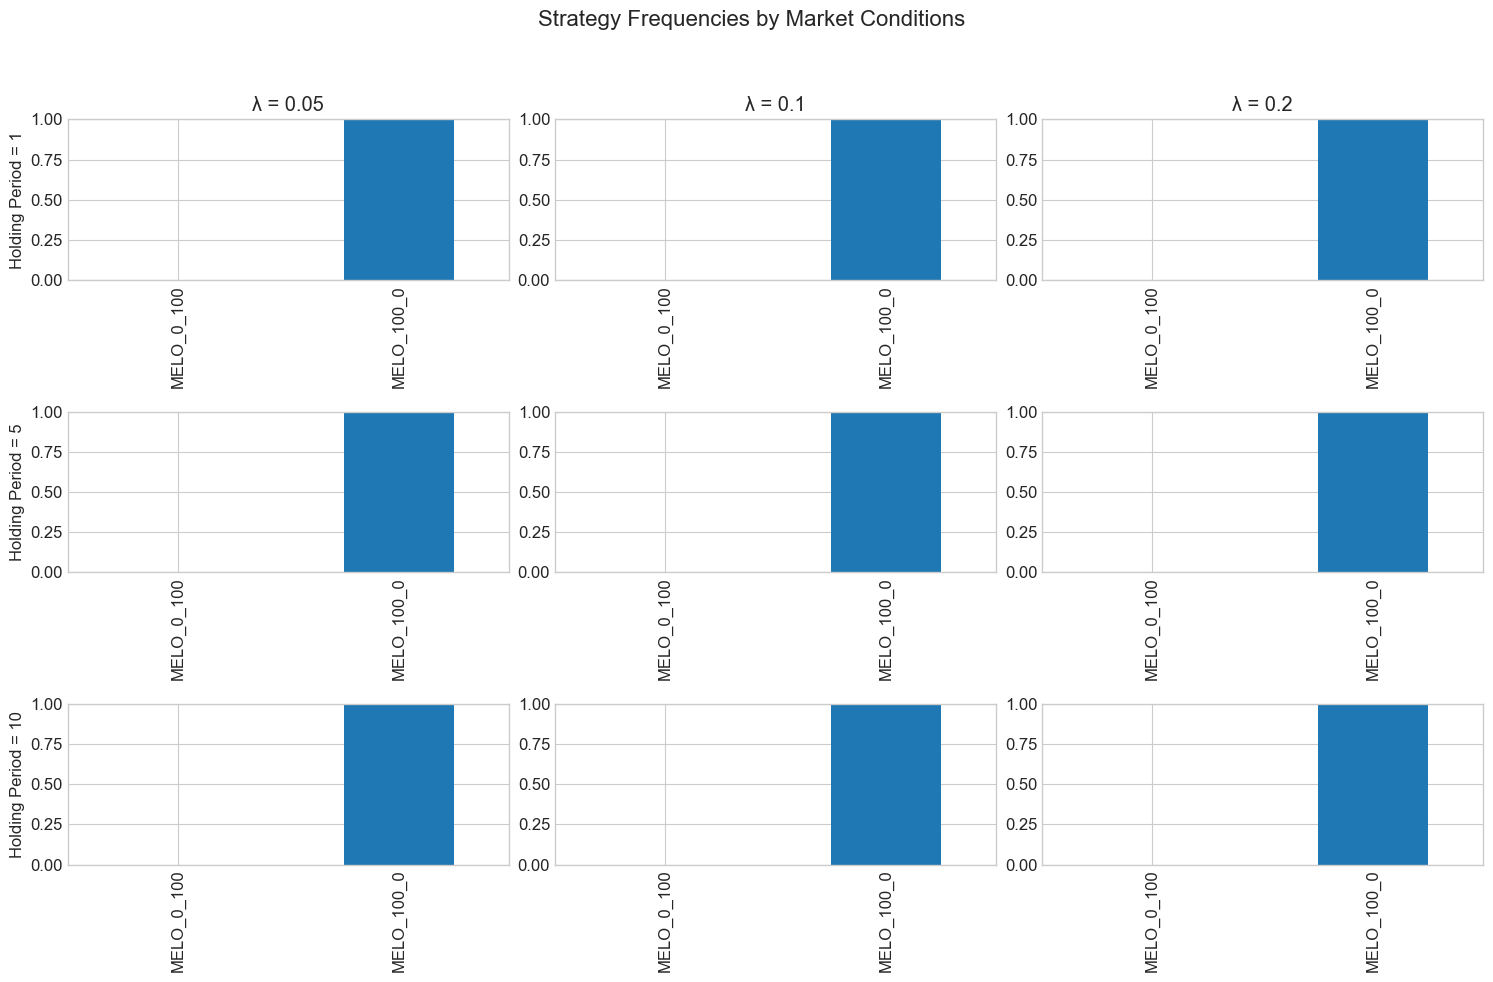

In [16]:
sweep_df = pd.DataFrame(results)

def get_top_strategy(row):
    if row['top_strategies']:
        return row['top_strategies'][0][0] 
    return None

sweep_df['top_strategy'] = sweep_df.apply(get_top_strategy, axis=1)

pivot = pd.pivot_table(
    sweep_df, 
    values='top_strategy', 
    index='holding_period', 
    columns='lam',
    aggfunc=lambda x: x
)

print("Top strategy by holding period and arrival rate:")
display(pivot)

plt.figure(figsize=(12, 8))
strategies = simulator.get_strategies()

fig, axes = plt.subplots(len(holding_periods), len(lambdas), figsize=(15, 10))
fig.suptitle('Strategy Frequencies by Market Conditions', fontsize=16)

for i, h in enumerate(holding_periods):
    axes[i, 0].set_ylabel(f'Holding Period = {h}')
    
for j, lam in enumerate(lambdas):
    axes[0, j].set_title(f'λ = {lam}')

for i, h in enumerate(holding_periods):
    for j, lam in enumerate(lambdas):
        result = next((r for r in results if r['holding_period'] == h and r['lam'] == lam), None)
        if result:
            freqs = pd.Series(result['strategy_frequencies'])
            freqs.plot(kind='bar', ax=axes[i, j])
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_ylim(0, 1)
            
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, 'parameter_sweep_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Advanced EGTA - Custom Strategy Space

Let's explore how to define and analyze a custom strategy space, with more fine-grained allocation proportions.

In [17]:
class CustomMeloSimulator(MeloSimulator):
    """Extended MeloSimulator with custom strategy space."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # more fine-grained strategy space
        self.strategies = [
            "MELO_100_0",   # 100% CDA, 0% MELO
            "MELO_90_10",   # 90% CDA, 10% MELO
            "MELO_80_20",   # 80% CDA, 20% MELO
            "MELO_70_30",   # 70% CDA, 30% MELO
            "MELO_60_40",   # 60% CDA, 40% MELO
            "MELO_50_50",   # 50% CDA, 50% MELO
            "MELO_40_60",   # 40% CDA, 60% MELO
            "MELO_30_70",   # 30% CDA, 70% MELO
            "MELO_20_80",   # 20% CDA, 80% MELO
            "MELO_10_90",   # 10% CDA, 90% MELO
            "MELO_0_100",   # 0% CDA, 100% MELO
        ]
        
        # strategy parameters
        self.strategy_params = {}
        for strategy in self.strategies:
            # Parse the strategy name to get proportions
            parts = strategy.split('_')
            cda_prop = int(parts[1]) / 100
            melo_prop = int(parts[2]) / 100
            self.strategy_params[strategy] = {
                "cda_proportion": cda_prop,
                "melo_proportion": melo_prop
            }

In [18]:
custom_output_dir = f"{output_dir}/custom_strategy_space"
os.makedirs(custom_output_dir, exist_ok=True)

custom_simulator = CustomMeloSimulator(
    num_players=10,
    sim_time=1000,
    lam=0.1,
    holding_period=5,
    reps=2  # Use fewer repetitions for speed
)

#Print available strategies
strategies = custom_simulator.get_strategies()
print(f"Available strategies: {strategies}")

#Print strategy parameters
print("\nStrategy parameters:")
for strategy in strategies:
    params = custom_simulator.strategy_params[strategy]
    print(f"  {strategy}: CDA={params['cda_proportion']:.2f}, MELO={params['melo_proportion']:.2f}")

TypeError: MeloSimulator.__init__() got an unexpected keyword argument 'num_players'

In [19]:
custom_scheduler = RandomScheduler(
    strategies=strategies,
    num_players=custom_simulator.get_num_players(),
    batch_size=5,
    seed=42
)

custom_egta = EGTA(
    simulator=custom_simulator,
    scheduler=custom_scheduler,
    device="cpu",
    output_dir=custom_output_dir,
    max_profiles=40,
    seed=42
)

In [ ]:
print("Starting EGTA experiment with custom strategy space...")
print(f"Analyzing {len(strategies)} different allocation strategies")

custom_game = custom_egta.run(
    max_iterations=4,
    profiles_per_iteration=5,
    save_frequency=1,
    verbose=True
)

print("\nEGTA experiment completed!")

In [ ]:
custom_analysis = custom_egta.analyze_equilibria(verbose=True)

with open(os.path.join(custom_output_dir, 'analysis.json'), 'w') as f:
    json.dump(custom_analysis, f, indent=2)

In [ ]:
custom_vis_dir = os.path.join(custom_output_dir, 'visualizations')
custom_report_path = create_visualization_report(
    game=custom_game,
    equilibria=custom_egta.equilibria,
    output_dir=custom_vis_dir
)

print(f"Visualization report saved to {custom_report_path}")

## 7. Analysis of Optimal Allocation Curve

## TODO, WE MIGHT want some analysis of metrics, stats. 


In [23]:
def run_holding_period_sweep(holding_periods):
    """Run experiments across different holding periods."""
    sweep_results = []
    
    for holding_period in tqdm(holding_periods):
        # Create experiment directory
        exp_dir = f"{output_dir}/holding_sweep_{holding_period}"
        os.makedirs(exp_dir, exist_ok=True)
        
        # Create simulator with specific holding period
        sim = CustomMeloSimulator(
            num_players=10,
            sim_time=1000,
            lam=0.1,
            holding_period=holding_period,
            reps=2
        )
        
        # Create scheduler
        sched = DPRScheduler(
            strategies=sim.get_strategies(),
            num_players=sim.get_num_players(),
            subgame_size=5,  # Use a larger subgame size for more exploration
            batch_size=4,
            seed=42
        )
        
        # Create EGTA framework
        egta_instance = EGTA(
            simulator=sim,
            scheduler=sched,
            device="cpu",
            output_dir=exp_dir,
            max_profiles=30,
            seed=42
        )
        
        # Run EGTA
        game = egta_instance.run(
            max_iterations=3,
            profiles_per_iteration=4,
            save_frequency=1,
            verbose=False
        )
        
        # Analyze equilibria
        analysis = egta_instance.analyze_equilibria(verbose=False)
        
        # Extract CDA proportions from top strategies
        cda_proportions = []
        for eq_mix, _ in egta_instance.equilibria:
            eq_strat_freqs = dict(zip(game.strategy_names, eq_mix.tolist()))
            weighted_cda_prop = 0
            for strat, freq in eq_strat_freqs.items():
                if freq > 0.01:  # Only count strategies with significant probability
                    cda_prop = sim.strategy_params[strat]['cda_proportion']
                    weighted_cda_prop += cda_prop * freq
            cda_proportions.append(weighted_cda_prop)
        
        # Calculate average CDA proportion
        avg_cda_prop = np.mean(cda_proportions) if cda_proportions else None
        
        # Save results
        result = {
            'holding_period': holding_period,
            'avg_cda_proportion': avg_cda_prop,
            'cda_proportions': cda_proportions,
            'num_equilibria': len(egta_instance.equilibria),
            'top_strategies': analysis['top_strategies']
        }
        sweep_results.append(result)
        
    return sweep_results

In [ ]:
# Run a sweep across different holding periods
holding_periods = [1, 2, 3, 5, 7, 10, 15, 20]
holding_sweep_results = run_holding_period_sweep(holding_periods)

# Save results
with open(os.path.join(output_dir, 'holding_period_sweep_results.json'), 'w') as f:
    json.dump(holding_sweep_results, f, indent=2)

In [ ]:
# Create a dataframe from results
holding_df = pd.DataFrame(holding_sweep_results)

# Plot the relationship between holding period and CDA proportion
plt.figure(figsize=(10, 6))
plt.plot(holding_df['holding_period'], holding_df['avg_cda_proportion'], 'o-', linewidth=2, markersize=8)
plt.xlabel('MELO Holding Period')
plt.ylabel('Average CDA Proportion in Equilibrium')
plt.title('Optimal CDA Allocation vs. MELO Holding Period')
plt.grid(True)
plt.ylim(0, 1)
plt.savefig(os.path.join(output_dir, 'optimal_allocation_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

# Display the data
display(holding_df[['holding_period', 'avg_cda_proportion', 'num_equilibria']])